# Stop Using Earnings to Benchmark Your Trading Strategies
*by Marco Moscatelli*

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import math
import sys

In [ ]:
# Download historical data
data_downloaded = yf.download("EURUSD=X", start="2014-01-01", end="2024-01-01")

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

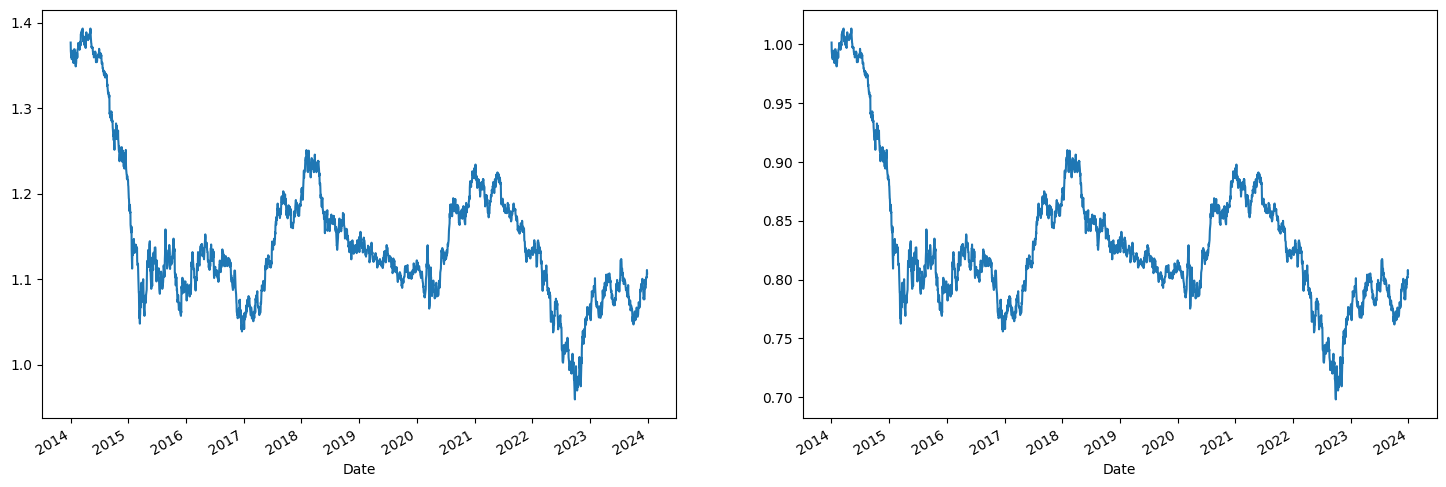

In [58]:
data_returns = data_downloaded.copy()

# Only Adj Close is needed
data_returns = data_returns[['Adj Close']]

# Calculate log returns and add as a new column called 'returns'
data_returns['returns'] = np.log(data_returns['Adj Close'] / data_returns['Adj Close'].shift(1))

# Drop any rows with NaN values resulting from the shift
data_returns = data_returns.dropna()

# Plot adj close and cumsum of returns to show that they are the same
fig, ax = plt.subplots(1, 2, figsize=[18, 6])
data_returns["Adj Close"].plot(ax=ax[0])
data_returns["returns"].cumsum().apply(np.exp).plot(ax=ax[1])

<Axes: xlabel='Date'>

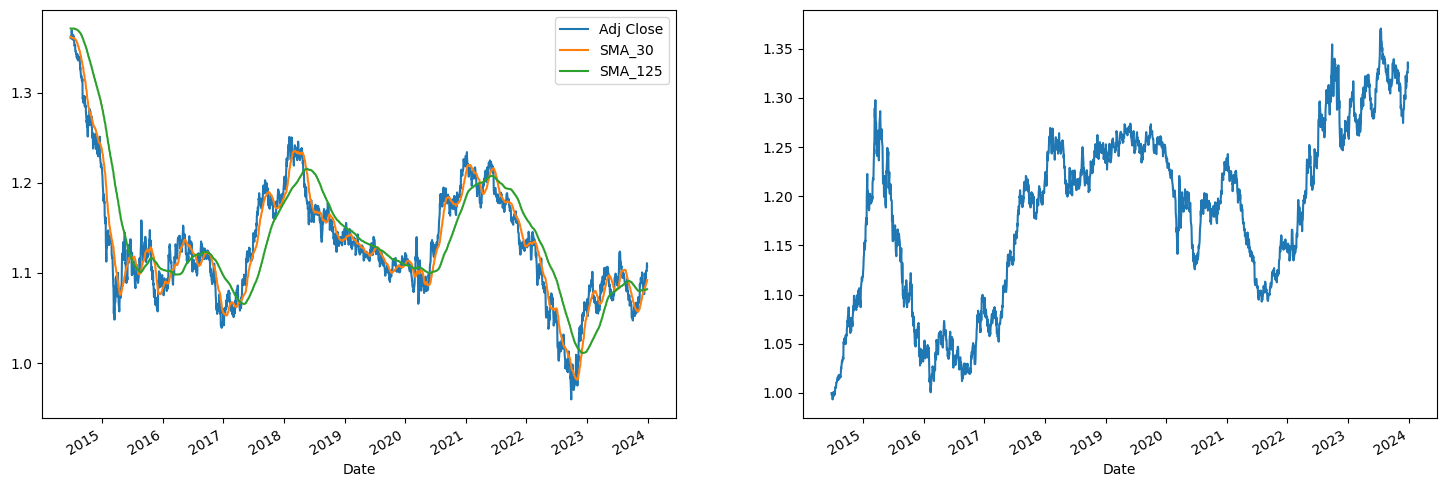

In [ ]:
data_ma = data_returns.copy()

short_SMA = 30
long_SMA = 125

# Create moving average strategy
data_ma[f'SMA_{short_SMA}'] = data_ma['Adj Close'].rolling(window=short_SMA).mean()
data_ma[f'SMA_{long_SMA}'] = data_ma['Adj Close'].rolling(window=long_SMA).mean()
data_ma["SMA_position"] = np.where(data_ma[f'SMA_{short_SMA}'] > data_ma[f'SMA_{long_SMA}'], 1, -1)
data_ma["SMA_position"] = data_ma["SMA_position"].shift(1)

# Drop NaNs
data_ma.dropna(inplace=True)

data_ma["SMA_returns"] = data_ma["returns"] * data_ma["SMA_position"]
data_ma["SMA_strategy"] = data_ma["SMA_returns"].cumsum().apply(np.exp)

# Plot
fig, ax = plt.subplots(1, 2, figsize=[18, 6])
data_ma[["Adj Close", f'SMA_{short_SMA}', f'SMA_{long_SMA}']].plot(ax=ax[0])
data_ma["SMA_strategy"].plot(ax=ax[1])

In [24]:
data_monte_carlo = data_ma.copy()

# Run Monte Carlo Simulation
n_simulations = 1000
results = []
for i in range(n_simulations):
  results.append(((data_monte_carlo['returns'] * np.random.choice([-1, 1], size=len(data_monte_carlo['returns'])).cumsum()).apply(np.exp)).tolist())

In [25]:
result_to_reach = data_monte_carlo["SMA_strategy"].iloc[-1]
losses = 0
for i in range(n_simulations):
  if results[i][-1] >= result_to_reach:
    losses += 1

### Probability that your strategy will win against a random strategy

If our strategy is better than a random strategy that I would have a probabiliy of winning > 50%.

If the strategy that we have implemented uses knowledge and informations that means that will always beat a random strategy when N as the number of trials or days of trading approaches infinity.

If the strategy that we are testing is random, then the probability of being beaten by "random investing" will tend asymptotically toward 50%.

In [26]:
(1 - losses/n_simulations)

0.9359999999999999

### Probability that your strategy will win against a random agent strategy across time


In [ ]:
data_beats_random = data_monte_carlo.copy()

# Apply the simulation for the last N parameters in the strategy to understand how it develops over time
window_length = 100
n_simulations = 300

beats_random = np.zeros(len(data_beats_random))
for i in range(len(data_beats_random) - window_length):
    sys.stdout.write(f"\rSimulation: {i + 1}/{len(data_beats_random) - window_length}")
    sys.stdout.flush()
    results = []
    for j in range(n_simulations):
      results.append(np.exp(np.array((data_beats_random['returns'].iloc[i: i + window_length] * np.random.choice([-1, 1], size=window_length))).sum()) - 1)

    result_to_reach = data_beats_random["SMA_strategy"].iloc[i + window_length] - data_beats_random["SMA_strategy"].iloc[i]

    losses = 0
    for j in range(len(results)):
      if results[j] >= result_to_reach:
        losses += 1

    beats_random[i + window_length] = (1 - losses/len(results))

data_beats_random["beats_random"] = beats_random
data_beats_random = data_beats_random.iloc[window_length:] # Remove from the dataframe the simulations window_length

Simulation: 2380/2380

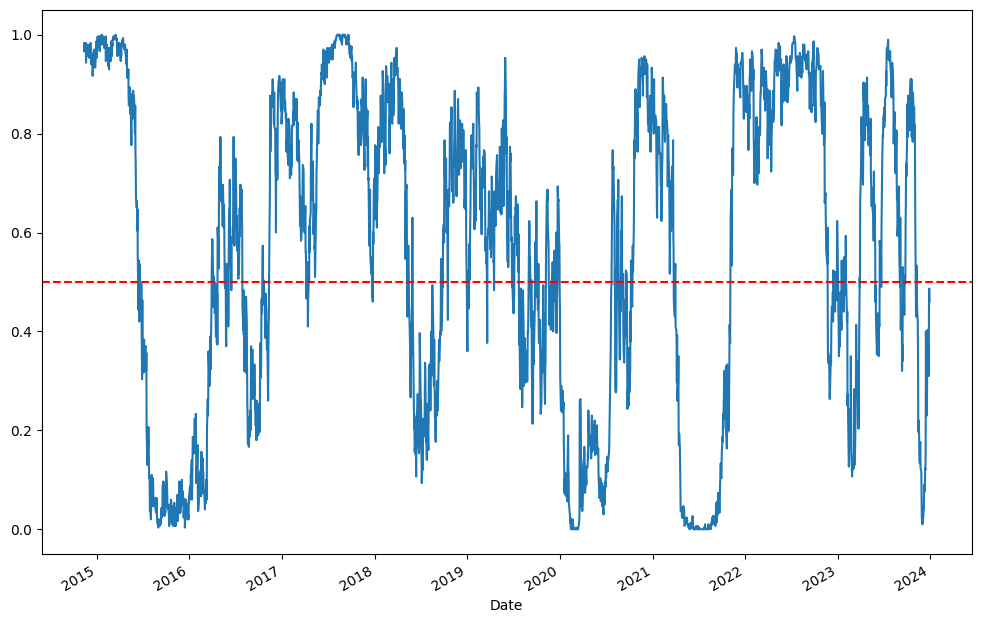

In [59]:
# Plot random-agents metric across time
plt.figure(figsize=[12, 8])
data_beats_random["beats_random"].plot()
plt.axhline(y=0.5, color='red', linestyle='--')

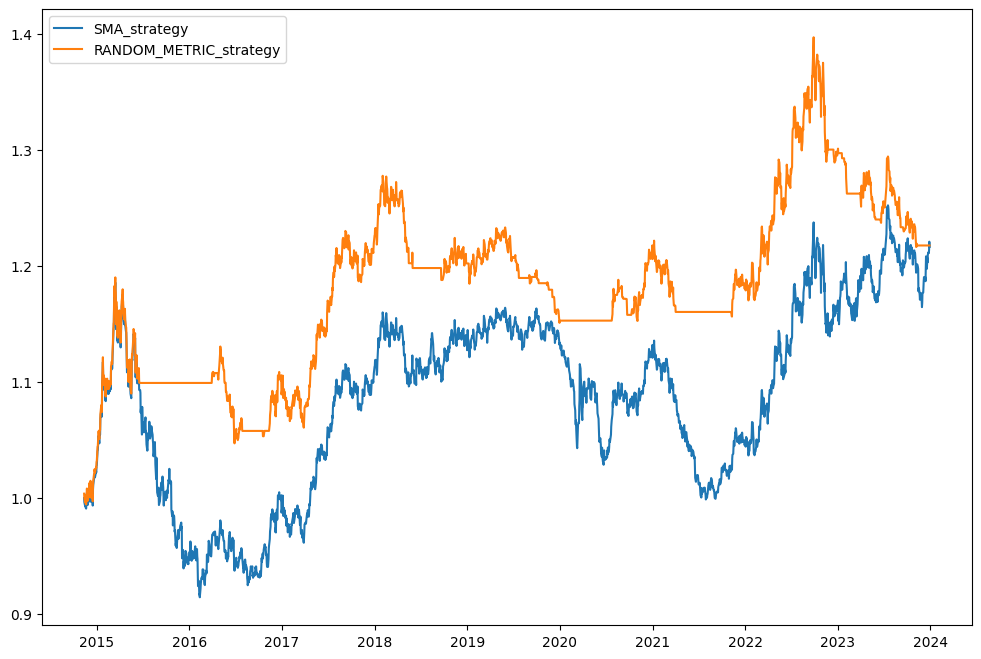

In [70]:
data_not_random_strategy = data_beats_random.copy()

accepted_risk_threshold = 0.50

# Show how our strategy performs against the simple moving average crossover strategy
data_not_random_strategy["RANDOM_METRIC_position"] = np.where(data_not_random_strategy["beats_random"] > accepted_risk_threshold, 1, 0)
data_not_random_strategy["RANDOM_METRIC_position"] = data_not_random_strategy["RANDOM_METRIC_position"].shift(1)
data_not_random_strategy["RANDOM_METRIC_returns"] = data_not_random_strategy["SMA_returns"] * data_not_random_strategy["RANDOM_METRIC_position"]
data_not_random_strategy["RANDOM_METRIC_strategy"] = data_not_random_strategy["RANDOM_METRIC_returns"].cumsum().apply(np.exp)

# Corrected SMA strategy
# This is needed or else the graph could start from a value different from 1
data_not_random_strategy["SMA_strategy"] = data_not_random_strategy["SMA_returns"].cumsum().apply(np.exp)

data_not_random_strategy.dropna(inplace=True)

plt.figure(figsize=[12, 8])
plt.plot(data_not_random_strategy[["SMA_strategy", "RANDOM_METRIC_strategy"]])
plt.legend(["SMA_strategy", "RANDOM_METRIC_strategy"])

In [ ]:
# Understand how many times the random-agents metric is below the accepted threshold
data_not_random_strategy["RANDOM_position"].value_counts()

1.0    1407
0.0     972
Name: RANDOM_position, dtype: int64

### Sharpe Ratio Analysis

In [57]:
sharpe_ratio_sma = (np.mean(data_not_random_strategy["SMA_returns"]) * 252) / (np.std(data_not_random_strategy["SMA_returns"]) * math.sqrt(252))
sharpe_ratio_random = (np.mean(data_not_random_strategy["RANDOM_returns"]) * 252) / (np.std(data_not_random_strategy["RANDOM_returns"]) * math.sqrt(252))

sharpe_ratio_sma, sharpe_ratio_random

(0.26137350706224094, 0.3286957278567311)